# MLOps Workflow for Model Deployment in Client Projects

In this walkthrough, you will manage an ML workflow for deploying a scalable predictive model for a financial client.

**Scenario:**
Your financial services client wants a fraud detection model that can scale across multiple regions with minimal downtime. Your team is responsible for deploying the model and ensuring version contro

**Objective:**
- Preprocess the dataset for model training and train the model
- Use MLflow to track experiments, hyperparameters, and model versions.

### Part 1: Load the 'fraud_detection_dataset.csv' dataset into a pandas Dataframe
**Task 1:**
- Load and Preprocess the dataset.
- Split the dataset into training and testing datasets

In [1]:
from sklearn.datasets import make_classification  
import pandas as pd  


data=pd.read_csv("../data/fraud_detection_dataset.csv")  

In [2]:
data.head()

step      type   amount nameOrg  oldbalanceOrg  newbalanceOrg nameDest  \
0   103  TRANSFER  4215.77  C30199        9962.31        5746.54    C7645   
1   436   CASH_IN  2805.48   C8699       16773.83       13968.35   C27141   
2   861  TRANSFER  8950.44  C26191       15865.27        6914.83   C20483   
3   271     DEBIT  3322.40    C973        8259.44        4937.04    C7632   
4   107   CASH_IN  5785.97  C13679       19524.09       13738.12   C35689   

   oldbalanceDest  newbalanceDest  isFraud  
0        18118.40        18118.40        0  
1        13150.58        15956.06        0  
2        10882.61        10882.61        0  
3         8104.84        11427.24        0  
4         5044.86        10830.83        0

In [3]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()

step      type   amount nameOrg  oldbalanceOrg  newbalanceOrg nameDest  \
0   103  TRANSFER  4215.77  C30199        9962.31        5746.54    C7645   
1   436   CASH_IN  2805.48   C8699       16773.83       13968.35   C27141   
2   861  TRANSFER  8950.44  C26191       15865.27        6914.83   C20483   
3   271     DEBIT  3322.40    C973        8259.44        4937.04    C7632   
4   107   CASH_IN  5785.97  C13679       19524.09       13738.12   C35689   

   oldbalanceDest  newbalanceDest  isFraud  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0        18118.40        18118.40        0     False  False    False      True  
1        13150.58        15956.06        0     False  False    False     False  
2        10882.61        10882.61        0     False  False    False      True  
3         8104.84        11427.24        0     False   True    False     False  
4         5044.86        10830.83        0     False  False    False     False

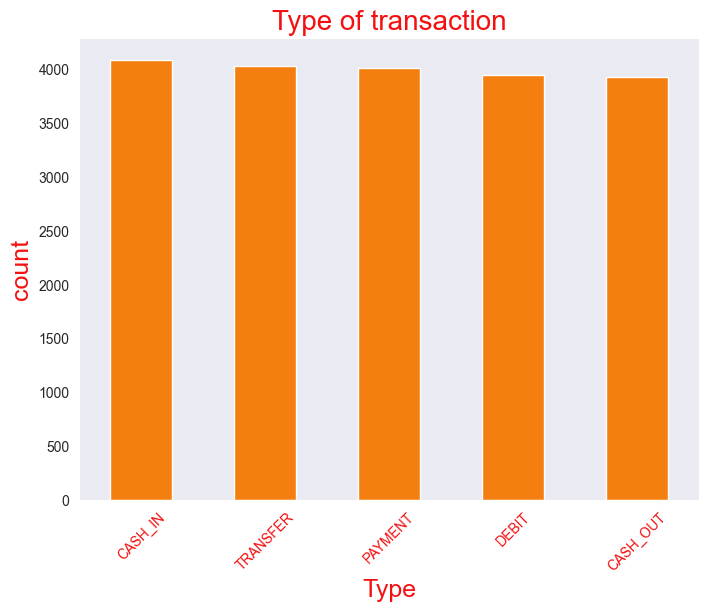

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark") # set the style of the plot as dark grid
sns.set_palette("pastel")
plt.figure(figsize = (8,6))
data['type'].value_counts().plot(kind = 'bar', color = '#F47F10')
plt.title('Type of transaction', color = '#F41010', fontsize = 20)
plt.xticks(rotation = 45, color = '#F41010')
plt.xlabel('Type', fontsize = 18, color = '#F41010')
plt.ylabel('count', fontsize = 18, color = '#F41010')
plt.show()

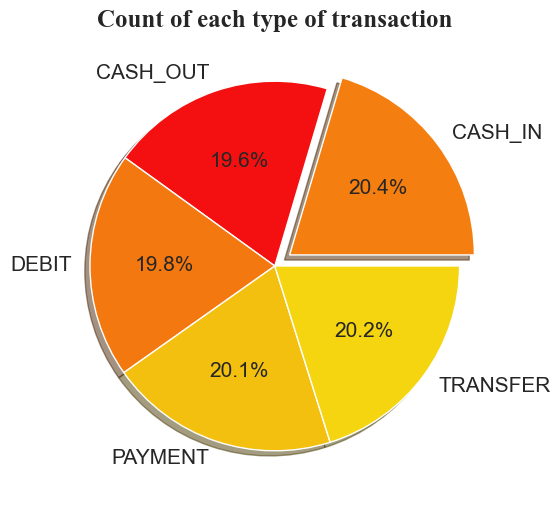

In [5]:
counts = data.groupby('type').count()['amount']
plt.figure(figsize = (6,6))
plt.pie(counts, labels = counts.index, autopct = "%1.1f%%", colors=['#F47F10', '#F41010', '#F47810', '#F4C010','#F4D510'], shadow = True,explode = (0.1, 0, 0, 0, 0),textprops={'fontsize': 15})
plt.title('Count of each type of transaction', fontweight = 'bold', fontsize = 18, fontfamily = 'times new roman')
plt.show()

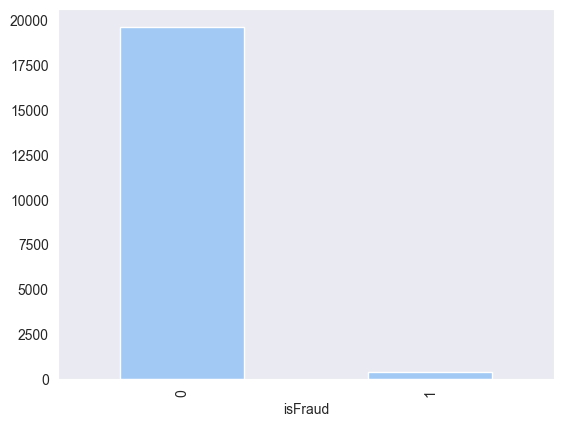

In [6]:
data['isFraud'].value_counts().plot(kind='bar')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split  

X = data_new.drop(['isFraud', 'type', 'nameOrg', 'nameDest'], axis=1)
y = data_new['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



### Part 2: Start a Local MLflow Server

**Task:**
- Install and import mlflow 
- Set the Tracking Server URI
- Train a model and prepare metadata for logging
- Start an MLflow run

In [ ]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, f1_score

import mlflow
import mlflow.sklearn  

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Fraud Detection")


def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test):  
    with mlflow.start_run(run_name=model_name):  
        # Train the model  
        model.fit(X_train, y_train)  

        # Predict and calculate metrics  
        predictions = model.predict(X_test)  
        accuracy = accuracy_score(y_test, predictions)  
        f1 = f1_score(y_test, predictions)  

        # Log parameters and metrics  
        mlflow.log_param("model_name", model_name)  
        mlflow.log_metric("accuracy", accuracy)  
        mlflow.log_metric("f1_score", f1)  

        # Log the model  
        mlflow.sklearn.log_model(model, artifact_path="model")  

# Train and log two models  
train_and_log_model(LogisticRegression(), "LogisticRegression", X_train, y_train, X_test, y_test)  
train_and_log_model(RandomForestClassifier(), "RandomForest", X_train, y_train, X_test, y_test)  